# FRC 2026 REBUILT - Lob Shooter Analysis
## Team 2491 Engineering Toolkit

This notebook provides interactive tools for analyzing **lob trajectories** for the 2026 FRC game.

### Key Insight: Ball Must DESCEND Into Funnel
The target is a funnel with the opening facing **UP**. Like throwing a ball into a trash can, we need HIGH-ANGLE shots that arc up and come DOWN into the opening.

### Game Constraints
- **Projectile (FUEL):** 5.91" diameter foam ball, ~0.47 lbs
- **Target:** 72" high funnel opening facing UP
- **Robot:** Max 30" height, practical release ~18"
- **Shooting Range:** 24" (2 ft) to 250" (21 ft) - full alliance zone
- **Recommended Velocity:** 34 ft/s (covers full range with steep entry angles)

---
## 1. Setup and Constants

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Polygon
from ipywidgets import interact, interactive, FloatSlider, IntSlider, Dropdown, HBox, VBox
import ipywidgets as widgets
from IPython.display import display, Markdown

# Enable interactive plots
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['font.size'] = 11

# Physical constants
G = 386.09  # in/s^2 (gravity in imperial)

# Game piece properties
FUEL_DIAMETER_IN = 5.91
FUEL_MASS_LB = 0.47
FUEL_MASS_KG = FUEL_MASS_LB * 0.4536

# Target properties
TARGET_HEIGHT_IN = 72

# Shooting range
MIN_DISTANCE_IN = 24   # 2 ft minimum
MAX_DISTANCE_IN = 250  # ~21 ft maximum (alliance zone corner)

# Recommended velocity (covers full range with steep entry)
RECOMMENDED_VELOCITY_FPS = 30

# Robot constraints
ROBOT_MAX_HEIGHT_IN = 30
RELEASE_HEIGHT_IN = 18

print("LOB SHOOTER ANALYSIS - Setup Complete")
print("=" * 50)
print(f"Gravity: {G} in/s^2")
print(f"Target height: {TARGET_HEIGHT_IN} in (funnel facing UP)")
print(f"Shooting range: {MIN_DISTANCE_IN}\" to {MAX_DISTANCE_IN}\"")
print(f"Recommended velocity: {RECOMMENDED_VELOCITY_FPS} ft/s")
print("=" * 50)

LOB SHOOTER ANALYSIS - Setup Complete
Gravity: 386.09 in/s^2
Target height: 72 in (funnel facing UP)
Shooting range: 24" to 250"
Recommended velocity: 30 ft/s


---
## 2. Understanding Lob Trajectories

### Why Lob Shots?

The target is a **funnel facing UP**. This means:
- Ball must be **DESCENDING** (vy < 0) when it reaches the target height
- Ball arcs **UP** above the target, then falls **DOWN** into the opening
- Higher entry angles = steeper descent = better capture

**Analogy:** Like throwing a ball into a tall trash can - you lob it up so it falls in from above.

### Key Condition
For a valid lob shot, when the ball reaches `y = target_height` at `x = 0`:
- **vy must be NEGATIVE** (ball going down, not up)
- This eliminates "line drive" trajectories that pass through the target while ascending

### Entry Angle Quality
- **IDEAL (60-90°):** Steep descent, high capture rate
- **GOOD (45-60°):** Reliable capture
- **RISKY (<45°):** May bounce off funnel walls

In [16]:
def find_lob_solution(distance_in, velocity_fps=RECOMMENDED_VELOCITY_FPS, 
                      release_height=RELEASE_HEIGHT_IN, vx_robot=0, vy_robot=0):
    """
    Find the launch angle for a LOB trajectory where ball DESCENDS into target.
    
    CRITICAL: Only returns solutions where vy < 0 at target (ball descending).
    
    Returns: dict with angle, entry_angle, max_height, etc. or None if no solution
    """
    v_shot = velocity_fps * 12  # Convert to in/s
    
    best_solution = None
    best_entry_angle = 0
    
    # Scan from low to high angles
    for theta_deg in np.linspace(5, 89, 2000):
        theta = np.radians(theta_deg)
        
        # Combined initial velocity
        vx0 = v_shot * np.cos(theta) + vx_robot
        vy0 = v_shot * np.sin(theta) + vy_robot
        
        if vx0 <= 0:
            continue
        
        # Time to reach target x-position
        t_hit = distance_in / vx0
        
        # Height and vertical velocity at target
        y_at_target = release_height + vy0 * t_hit - 0.5 * G * t_hit**2
        vy_at_target = vy0 - G * t_hit
        
        # CRITICAL: Ball must be at target height AND DESCENDING
        if abs(y_at_target - TARGET_HEIGHT_IN) < 2.5 and vy_at_target < 0:
            # Entry angle = how steeply ball is descending
            entry_angle = np.degrees(np.arctan2(abs(vy_at_target), vx0))
            
            # Keep solution with steepest entry (best for funnel)
            if entry_angle > best_entry_angle:
                best_entry_angle = entry_angle
                
                # Calculate max height
                t_apex = vy0 / G
                max_height = release_height + vy0 * t_apex - 0.5 * G * t_apex**2
                
                best_solution = {
                    'angle_deg': theta_deg,
                    'entry_angle_deg': entry_angle,
                    't_flight': t_hit,
                    'max_height': max_height,
                    'y_at_target': y_at_target,
                    'vy_at_target': vy_at_target,
                    'vx0': vx0,
                    'vy0': vy0
                }
    
    return best_solution


def calculate_trajectory(distance_in, velocity_fps, theta_deg, release_height=RELEASE_HEIGHT_IN,
                        vx_robot=0, vy_robot=0):
    """Calculate full trajectory points for plotting."""
    v_shot = velocity_fps * 12
    theta = np.radians(theta_deg)
    
    vx0 = v_shot * np.cos(theta) + vx_robot
    vy0 = v_shot * np.sin(theta) + vy_robot
    
    if vx0 <= 0:
        return np.array([0]), np.array([distance_in]), np.array([release_height])
    
    t_max = 3.0  # Max 3 seconds
    t = np.linspace(0, t_max, 500)
    
    x = distance_in - vx0 * t
    y = release_height + vy0 * t - 0.5 * G * t**2
    
    # Keep valid portion (above ground, not past target)
    valid = (x >= -20) & (y >= -5)
    return t[valid], x[valid], y[valid]


# Test the function
print("Testing lob solution finder...")
test_dist = 84  # 7 ft
solution = find_lob_solution(test_dist)

if solution:
    print(f"\nFor {test_dist/12:.0f} ft shot at {RECOMMENDED_VELOCITY_FPS} fps:")
    print(f"  Launch angle: {solution['angle_deg']:.1f} deg")
    print(f"  Entry angle:  {solution['entry_angle_deg']:.1f} deg (ball descending)")
    print(f"  Max height:   {solution['max_height']:.0f} in")
    print(f"  Flight time:  {solution['t_flight']:.2f} s")
else:
    print("No valid lob solution found!")

Testing lob solution finder...

For 7 ft shot at 30 fps:
  Launch angle: 82.0 deg
  Entry angle:  80.3 deg (ball descending)
  Max height:   183 in
  Flight time:  1.68 s


---
## 3. Interactive Lob Trajectory Visualization

Use the sliders to explore how distance and robot motion affect the lob trajectory.

**Key observations:**
- The ball arcs HIGH above the target, then falls DOWN into the funnel
- Entry angles are steep (60-90 deg) - excellent for funnel capture
- Launch angles are high (70-88 deg) - these are true lob shots

In [17]:
def plot_lob_trajectory_interactive(distance_ft=7, velocity_fps=30, robot_velocity_fps=0):
    """Interactive lob trajectory plotter."""
    distance_in = distance_ft * 12
    vx_robot = robot_velocity_fps * 12
    
    # Find the lob solution
    solution = find_lob_solution(distance_in, velocity_fps, vx_robot=vx_robot)
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    if solution:
        # Calculate trajectory
        t, x, y = calculate_trajectory(distance_in, velocity_fps, solution['angle_deg'],
                                       vx_robot=vx_robot)
        
        # Left plot: Trajectory
        ax1.plot(x, y, 'b-', linewidth=3, label='Lob trajectory')
        ax1.plot(distance_in, RELEASE_HEIGHT_IN, 'ko', markersize=12, label='Release point')
        
        # Mark apex
        ax1.plot(x[np.argmax(y)], np.max(y), 'g^', markersize=12, label=f'Apex: {solution["max_height"]:.0f}"')
        
        # Draw entry arrow showing descent
        ax1.annotate('', xy=(0, TARGET_HEIGHT_IN), xytext=(15, TARGET_HEIGHT_IN + 25),
                    arrowprops=dict(arrowstyle='->', color='red', lw=3))
        ax1.annotate(f'{solution["entry_angle_deg"]:.0f} deg\ndescent', (18, TARGET_HEIGHT_IN + 15),
                    fontsize=11, color='red', fontweight='bold')
    
    # Funnel target (opening faces UP)
    ax1.plot([0, -10], [TARGET_HEIGHT_IN, TARGET_HEIGHT_IN-25], 'k-', linewidth=4)
    ax1.plot([0, 10], [TARGET_HEIGHT_IN, TARGET_HEIGHT_IN-25], 'k-', linewidth=4)
    ax1.plot([-25, 25], [TARGET_HEIGHT_IN, TARGET_HEIGHT_IN], 'g-', linewidth=5)
    ax1.fill_between([-25, 25], TARGET_HEIGHT_IN-3, TARGET_HEIGHT_IN+3, color='green', alpha=0.3)
    ax1.annotate('FUNNEL\n(opening UP)', (0, TARGET_HEIGHT_IN+12), ha='center', 
                fontsize=10, fontweight='bold')
    
    # Robot
    ax1.add_patch(Rectangle((distance_in-14, 0), 28, 20, color='gray', alpha=0.3))
    ax1.axhline(y=0, color='saddlebrown', linewidth=4)
    
    ax1.set_xlim(-40, distance_in + 40)
    ax1.set_ylim(-10, 260)
    ax1.set_xlabel('Distance from target (inches)', fontsize=12)
    ax1.set_ylabel('Height (inches)', fontsize=12)
    ax1.set_title(f'LOB Trajectory: {distance_ft} ft shot\nBall arcs UP then DESCENDS into funnel', fontsize=12)
    ax1.legend(loc='upper right', fontsize=9)
    ax1.grid(True, alpha=0.3)
    
    # Right plot: Metrics
    ax2.axis('off')
    
    if solution:
        # Determine quality
        if solution['entry_angle_deg'] >= 60:
            quality = "IDEAL"
            quality_color = "green"
        elif solution['entry_angle_deg'] >= 45:
            quality = "GOOD"
            quality_color = "orange"
        else:
            quality = "RISKY"
            quality_color = "red"
        
        metrics_text = f"""
    LOB SHOT ANALYSIS
    {'='*45}
    
    INPUT PARAMETERS
    Distance:        {distance_ft} ft ({distance_in} in)
    Muzzle velocity: {velocity_fps} ft/s
    Robot velocity:  {robot_velocity_fps:+d} ft/s toward target
    Release height:  {RELEASE_HEIGHT_IN} in
    
    {'='*45}
    
    LOB TRAJECTORY RESULTS
    Launch angle:    {solution['angle_deg']:.1f} deg (HIGH lob)
    Entry angle:     {solution['entry_angle_deg']:.1f} deg (DESCENDING)
    Max height:      {solution['max_height']:.0f} in (above target!)
    Flight time:     {solution['t_flight']:.2f} s
    
    {'='*45}
    
    The ball goes UP {solution['max_height'] - TARGET_HEIGHT_IN:.0f}" above
    the target, then falls DOWN into the funnel.
    
    Entry quality: {quality}
        """
        
        ax2.text(0.05, 0.95, metrics_text, transform=ax2.transAxes, fontsize=11,
                verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
        
        ax2.text(0.5, 0.08, quality, transform=ax2.transAxes, fontsize=36,
                ha='center', color=quality_color, fontweight='bold')
    else:
        ax2.text(0.5, 0.5, 'No valid lob solution\nat this distance/velocity', 
                transform=ax2.transAxes, fontsize=16, ha='center', color='red')
    
    plt.tight_layout()
    plt.show()

# Create interactive widget
interact(plot_lob_trajectory_interactive,
         distance_ft=IntSlider(min=2, max=21, step=1, value=7, description='Distance (ft)'),
         velocity_fps=IntSlider(min=25, max=40, step=1, value=30, description='Velocity (fps)'),
         robot_velocity_fps=IntSlider(min=-10, max=15, step=1, value=0, description='Robot vel'));

interactive(children=(IntSlider(value=7, description='Distance (ft)', max=21, min=2), IntSlider(value=30, desc…

---
## 4. Full Range Analysis (24" to 250")

Verify that 30 ft/s covers the entire alliance zone shooting range.

In [18]:
def analyze_full_range(velocity_fps=RECOMMENDED_VELOCITY_FPS):
    """Analyze lob solutions across the full shooting range."""
    
    print(f"LOB SHOOTER ANALYSIS - {velocity_fps} ft/s")
    print("=" * 75)
    print(f"{'Distance':>10} | {'Launch':>8} | {'Entry':>8} | {'Max Ht':>8} | {'Flight':>8} | {'Quality':>10}")
    print("-" * 75)
    
    results = []
    distances_in = list(range(24, 260, 12))  # 24" to 252" in 12" steps
    
    for dist_in in distances_in:
        solution = find_lob_solution(dist_in, velocity_fps)
        
        if solution:
            # Determine quality
            if solution['entry_angle_deg'] >= 60:
                quality = "IDEAL"
            elif solution['entry_angle_deg'] >= 45:
                quality = "GOOD"
            else:
                quality = "RISKY"
            
            results.append({
                'distance_in': dist_in,
                'distance_ft': dist_in / 12,
                **solution,
                'quality': quality
            })
            
            print(f"{dist_in/12:>8.1f} ft | {solution['angle_deg']:>6.1f} deg | "
                  f"{solution['entry_angle_deg']:>6.1f} deg | {solution['max_height']:>6.0f}\" | "
                  f"{solution['t_flight']:>6.2f} s | {quality:>10}")
        else:
            print(f"{dist_in/12:>8.1f} ft | {'--- NO SOLUTION ---':^50}")
    
    print("=" * 75)
    
    # Summary
    if results:
        min_entry = min(r['entry_angle_deg'] for r in results)
        max_entry = max(r['entry_angle_deg'] for r in results)
        ideal_count = sum(1 for r in results if r['quality'] == 'IDEAL')
        good_count = sum(1 for r in results if r['quality'] == 'GOOD')
        
        print(f"\nSUMMARY:")
        print(f"  Coverage: {results[0]['distance_ft']:.0f} ft to {results[-1]['distance_ft']:.0f} ft")
        print(f"  Entry angles: {min_entry:.0f} to {max_entry:.0f} deg")
        print(f"  Quality: {ideal_count} IDEAL, {good_count} GOOD out of {len(results)} distances")
    
    return results

# Run the analysis
results = analyze_full_range(30)

LOB SHOOTER ANALYSIS - 30 ft/s
  Distance |   Launch |    Entry |   Max Ht |   Flight |    Quality
---------------------------------------------------------------------------
     2.0 ft |                --- NO SOLUTION ---                
     3.0 ft |   86.6 deg |   85.8 deg |    185" |   1.69 s |      IDEAL
     4.0 ft |   85.5 deg |   84.5 deg |    185" |   1.69 s |      IDEAL
     5.0 ft |   84.3 deg |   83.1 deg |    184" |   1.69 s |      IDEAL
     6.0 ft |   83.2 deg |   81.8 deg |    183" |   1.69 s |      IDEAL
     7.0 ft |   82.0 deg |   80.3 deg |    183" |   1.68 s |      IDEAL
     8.0 ft |   80.8 deg |   78.9 deg |    182" |   1.68 s |      IDEAL
     9.0 ft |   79.7 deg |   77.5 deg |    180" |   1.67 s |      IDEAL
    10.0 ft |   78.5 deg |   76.1 deg |    179" |   1.67 s |      IDEAL
    11.0 ft |   77.2 deg |   74.5 deg |    178" |   1.65 s |      IDEAL
    12.0 ft |   75.9 deg |   73.0 deg |    176" |   1.65 s |      IDEAL
    13.0 ft |   74.6 deg |   71.4 deg | 

---
## 5. Trajectory Sweep Visualization

See how the lob trajectories look across the full range.

In [19]:
def plot_trajectory_sweep(velocity_fps=RECOMMENDED_VELOCITY_FPS):
    """Plot lob trajectories across the shooting range."""
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    # Left: Trajectories
    ax1 = axes[0]
    distances_ft = [2, 5, 8, 12, 16, 21]
    colors = plt.cm.viridis(np.linspace(0.15, 0.9, len(distances_ft)))
    
    for dist_ft, color in zip(distances_ft, colors):
        dist_in = dist_ft * 12
        solution = find_lob_solution(dist_in, velocity_fps)
        
        if solution:
            t, x, y = calculate_trajectory(dist_in, velocity_fps, solution['angle_deg'])
            ax1.plot(x, y, color=color, linewidth=2.5,
                    label=f"{dist_ft} ft: {solution['angle_deg']:.0f} deg launch, "
                          f"{solution['entry_angle_deg']:.0f} deg entry")
    
    # Funnel target
    ax1.plot([0, -10], [TARGET_HEIGHT_IN, TARGET_HEIGHT_IN-25], 'k-', linewidth=4)
    ax1.plot([0, 10], [TARGET_HEIGHT_IN, TARGET_HEIGHT_IN-25], 'k-', linewidth=4)
    ax1.plot([-30, 30], [TARGET_HEIGHT_IN, TARGET_HEIGHT_IN], 'g-', linewidth=5)
    ax1.fill_between([-30, 30], TARGET_HEIGHT_IN-3, TARGET_HEIGHT_IN+3, color='green', alpha=0.3)
    ax1.annotate('FUNNEL (opening UP)', (0, TARGET_HEIGHT_IN+12), ha='center', fontsize=10, fontweight='bold')
    
    ax1.axhline(y=0, color='saddlebrown', linewidth=4)
    
    ax1.set_xlim(-50, 280)
    ax1.set_ylim(-10, 260)
    ax1.set_xlabel('Distance from target (inches)', fontsize=12)
    ax1.set_ylabel('Height (inches)', fontsize=12)
    ax1.set_title(f'LOB Trajectory Sweep @ {velocity_fps} ft/s\nAll balls DESCEND into funnel', fontsize=12)
    ax1.legend(loc='upper right', fontsize=9)
    ax1.grid(True, alpha=0.3)
    
    # Right: Entry angle vs distance
    ax2 = axes[1]
    
    distances_range = np.linspace(24, 250, 50)
    entry_angles = []
    launch_angles = []
    
    for dist_in in distances_range:
        solution = find_lob_solution(dist_in, velocity_fps)
        if solution:
            entry_angles.append(solution['entry_angle_deg'])
            launch_angles.append(solution['angle_deg'])
        else:
            entry_angles.append(np.nan)
            launch_angles.append(np.nan)
    
    # Quality zones
    ax2.axhspan(60, 90, color='green', alpha=0.2, label='IDEAL (60-90 deg)')
    ax2.axhspan(45, 60, color='yellow', alpha=0.2, label='GOOD (45-60 deg)')
    ax2.axhspan(0, 45, color='red', alpha=0.15, label='RISKY (<45 deg)')
    
    ax2.plot(distances_range/12, entry_angles, 'b-', linewidth=3, label='Entry angle (descent)')
    ax2.plot(distances_range/12, launch_angles, 'r--', linewidth=2, label='Launch angle')
    
    ax2.set_xlim(1, 22)
    ax2.set_ylim(0, 95)
    ax2.set_xlabel('Distance (ft)', fontsize=12)
    ax2.set_ylabel('Angle (degrees)', fontsize=12)
    ax2.set_title(f'Entry Angle vs Distance @ {velocity_fps} ft/s\nSteeper entry = Better funnel capture', fontsize=12)
    ax2.legend(loc='right', fontsize=9)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Interactive version
interact(plot_trajectory_sweep,
         velocity_fps=IntSlider(min=30, max=40, step=1, value=30   , description='Velocity (fps)'));

interactive(children=(IntSlider(value=30, description='Velocity (fps)', max=40, min=30), Output()), _dom_class…

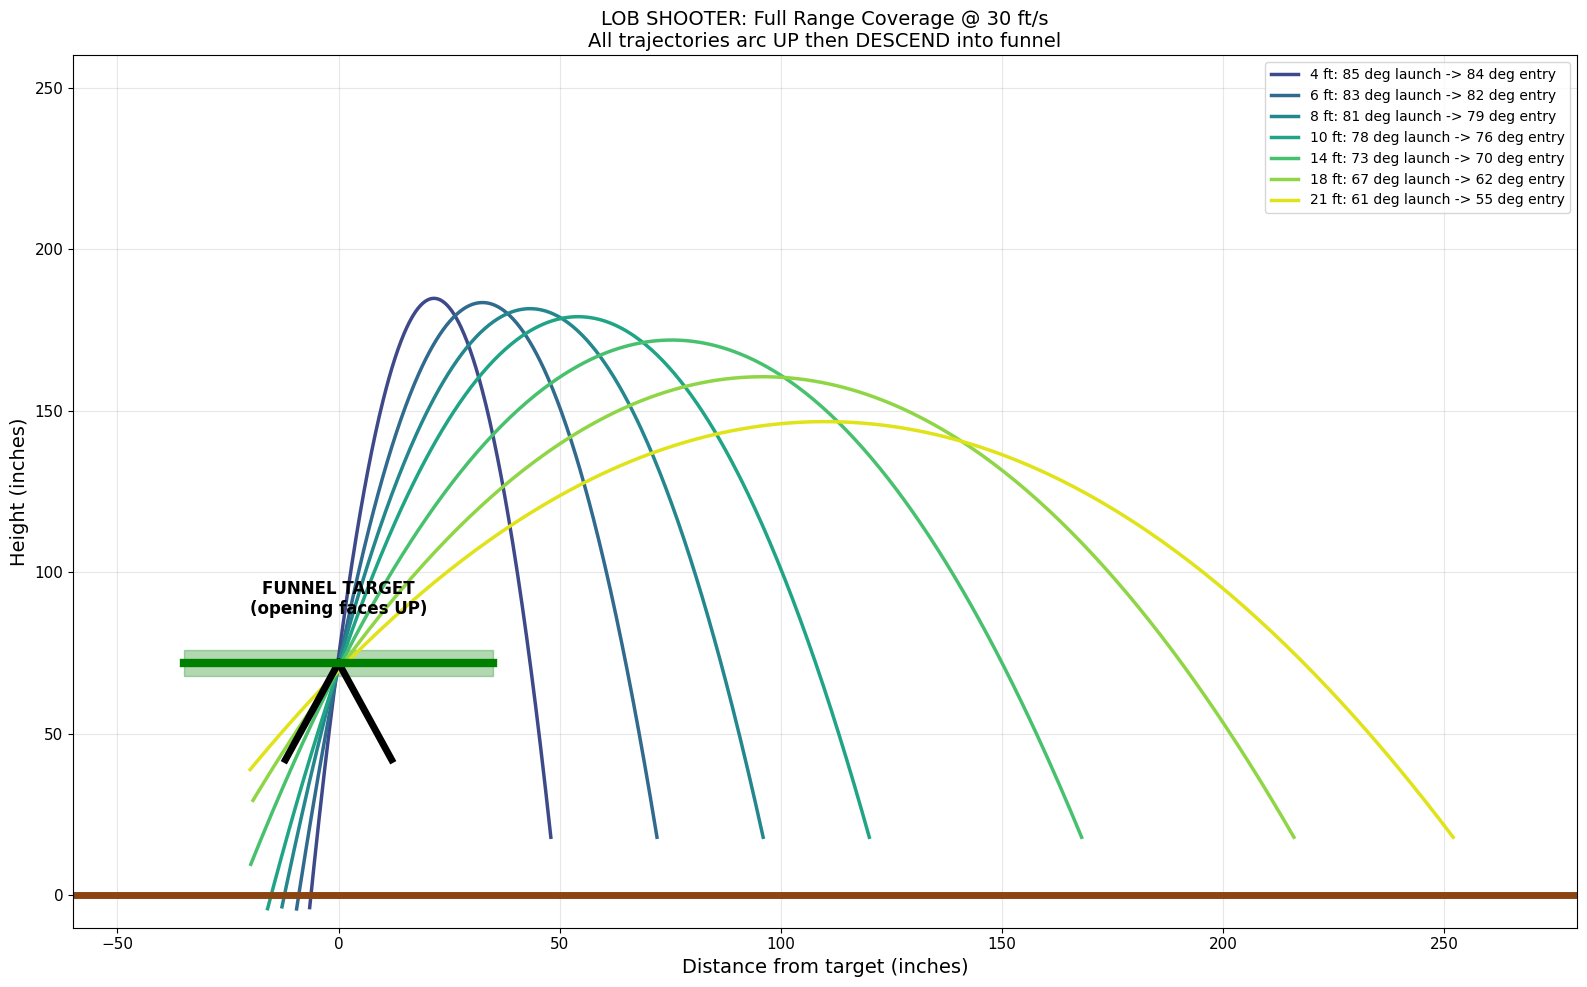

In [20]:
# Static version for export
def export_trajectory_plot():
    """Generate static trajectory plot for printing."""
    velocity_fps = 30
    
    fig, ax = plt.subplots(figsize=(16, 10))
    
    distances_ft = [2, 4, 6, 8, 10, 14, 18, 21]
    colors = plt.cm.viridis(np.linspace(0.1, 0.95, len(distances_ft)))
    
    for dist_ft, color in zip(distances_ft, colors):
        dist_in = dist_ft * 12
        solution = find_lob_solution(dist_in, velocity_fps)
        
        if solution:
            t, x, y = calculate_trajectory(dist_in, velocity_fps, solution['angle_deg'])
            ax.plot(x, y, color=color, linewidth=2.5,
                   label=f"{dist_ft} ft: {solution['angle_deg']:.0f} deg launch -> "
                         f"{solution['entry_angle_deg']:.0f} deg entry")
    
    # Funnel
    ax.plot([0, -12], [TARGET_HEIGHT_IN, TARGET_HEIGHT_IN-30], 'k-', linewidth=5)
    ax.plot([0, 12], [TARGET_HEIGHT_IN, TARGET_HEIGHT_IN-30], 'k-', linewidth=5)
    ax.plot([-35, 35], [TARGET_HEIGHT_IN, TARGET_HEIGHT_IN], 'g-', linewidth=6)
    ax.fill_between([-35, 35], TARGET_HEIGHT_IN-4, TARGET_HEIGHT_IN+4, color='green', alpha=0.3)
    ax.annotate('FUNNEL TARGET\n(opening faces UP)', (0, TARGET_HEIGHT_IN+15), 
               ha='center', fontsize=12, fontweight='bold')
    
    ax.axhline(y=0, color='saddlebrown', linewidth=5)
    
    ax.set_xlim(-60, 280)
    ax.set_ylim(-10, 260)
    ax.set_xlabel('Distance from target (inches)', fontsize=14)
    ax.set_ylabel('Height (inches)', fontsize=14)
    ax.set_title(f'LOB SHOOTER: Full Range Coverage @ {velocity_fps} ft/s\n'
                f'All trajectories arc UP then DESCEND into funnel', fontsize=14)
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

fig = export_trajectory_plot()
plt.show()

---
## 6. Robot Motion Effects

How does driving while shooting affect the lob trajectory?

In [ ]:
def plot_robot_velocity_effect(distance_ft=10, velocity_fps=34):
    """Show how robot motion affects the lob trajectory."""
    distance_in = distance_ft * 12
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # Left: Trajectories at different robot velocities
    ax1 = axes[0]
    robot_vels = [-10, -5, 0, 5, 10]
    colors = plt.cm.coolwarm(np.linspace(0, 1, len(robot_vels)))
    
    for v_robot_fps, color in zip(robot_vels, colors):
        vx_robot = v_robot_fps * 12
        solution = find_lob_solution(distance_in, velocity_fps, vx_robot=vx_robot)
        
        if solution:
            t, x, y = calculate_trajectory(distance_in, velocity_fps, solution['angle_deg'],
                                          vx_robot=vx_robot)
            direction = "toward" if v_robot_fps > 0 else "away" if v_robot_fps < 0 else "stationary"
            ax1.plot(x, y, color=color, linewidth=2.5,
                    label=f'{abs(v_robot_fps)} fps {direction}: {solution["angle_deg"]:.0f} deg')
    
    # Funnel
    ax1.plot([0, -8], [TARGET_HEIGHT_IN, TARGET_HEIGHT_IN-20], 'k-', linewidth=4)
    ax1.plot([0, 8], [TARGET_HEIGHT_IN, TARGET_HEIGHT_IN-20], 'k-', linewidth=4)
    ax1.plot([-25, 25], [TARGET_HEIGHT_IN, TARGET_HEIGHT_IN], 'g-', linewidth=5)
    ax1.axhline(y=0, color='saddlebrown', linewidth=4)
    
    ax1.set_xlim(-30, distance_in + 30)
    ax1.set_ylim(-10, 240)
    ax1.set_xlabel('Distance (inches)', fontsize=12)
    ax1.set_ylabel('Height (inches)', fontsize=12)
    ax1.set_title(f'Robot Motion Effect @ {distance_ft} ft\nAll are valid lob shots!', fontsize=12)
    ax1.legend(loc='upper right', fontsize=9)
    ax1.grid(True, alpha=0.3)
    
    # Right: Angle compensation chart
    ax2 = axes[1]
    
    robot_vels_range = np.linspace(-15, 15, 50)
    angles = []
    entry_angles = []
    
    for v_robot_fps in robot_vels_range:
        vx_robot = v_robot_fps * 12
        solution = find_lob_solution(distance_in, velocity_fps, vx_robot=vx_robot)
        if solution:
            angles.append(solution['angle_deg'])
            entry_angles.append(solution['entry_angle_deg'])
        else:
            angles.append(np.nan)
            entry_angles.append(np.nan)
    
    ax2.plot(robot_vels_range, angles, 'b-', linewidth=3, label='Launch angle')
    ax2.plot(robot_vels_range, entry_angles, 'g--', linewidth=2, label='Entry angle')
    ax2.axvline(x=0, color='gray', linestyle=':', alpha=0.5)
    
    ax2.annotate('Driving TOWARD target\n= adjust angle slightly', 
                xy=(8, 75), fontsize=10, ha='center')
    ax2.annotate('Driving AWAY\n= adjust angle slightly',
                xy=(-8, 75), fontsize=10, ha='center')
    
    ax2.set_xlim(-15, 15)
    ax2.set_ylim(50, 95)
    ax2.set_xlabel('Robot velocity toward target (ft/s)', fontsize=12)
    ax2.set_ylabel('Angle (degrees)', fontsize=12)
    ax2.set_title('Angle Compensation for Robot Motion\n(Both stay in IDEAL zone)', fontsize=12)
    ax2.legend(loc='lower right', fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

interact(plot_robot_velocity_effect,
         distance_ft=IntSlider(min=4, max=18, step=2, value=10, description='Distance (ft)'),
         velocity_fps=IntSlider(min=30, max=38, step=1, value=30, description='Velocity (fps)'));

interactive(children=(IntSlider(value=10, description='Distance (ft)', max=18, min=4, step=2), IntSlider(value…

---
## 7. Flywheel Requirements for Lob Shooter

At 30 ft/s, we need LESS flywheel energy than a high-velocity shooter. This is a WIN!

In [22]:
def calculate_flywheel_requirements(v_fps=45, num_balls=3, max_rpm_drop_pct=5, wheel_radius_in=2):
    """
    Calculate flywheel inertia requirements for multi-ball firing.
    
    Physics:
    - Energy stored in flywheel: E = ½Iω²
    - Energy transferred to ball: E = ½mv²
    - For small RPM drop: E_transferred << E_stored
    """
    # Convert units
    v_shot_m_s = v_fps * 12 * 0.0254  # m/s
    wheel_radius_m = wheel_radius_in * 0.0254  # m
    
    # Energy per ball
    E_ball = 0.5 * FUEL_MASS_KG * v_shot_m_s**2
    E_total = num_balls * E_ball
    
    # Angular velocity (assuming surface speed = ball speed)
    omega = v_shot_m_s / wheel_radius_m  # rad/s
    rpm = omega * 60 / (2 * np.pi)
    
    # For RPM drop of X%:
    # E_final/E_initial = (1 - X/100)²
    # E_transferred/E_initial = 1 - (1 - X/100)²
    drop_fraction = max_rpm_drop_pct / 100
    energy_fraction = 1 - (1 - drop_fraction)**2
    
    # Required stored energy
    E_required = E_total / energy_fraction
    
    # Required moment of inertia (total)
    I_total = 2 * E_required / omega**2
    I_per_wheel = I_total / 2  # Assuming 2 wheels
    
    # Convert to lb·in²
    I_per_wheel_lb_in2 = I_per_wheel / (0.0254**2 * 0.4536)
    
    # Estimate wheel mass (solid cylinder: I = ½mr²)
    wheel_mass_kg = 2 * I_per_wheel / wheel_radius_m**2
    wheel_mass_lb = wheel_mass_kg / 0.4536
    
    # Spin-up time estimate (2 NEO motors, ~2.6 N·m average)
    motor_torque = 2 * 2.6  # N·m
    spinup_time = I_total * omega / motor_torque
    
    return {
        'rpm': rpm,
        'energy_per_ball_J': E_ball,
        'total_energy_J': E_total,
        'stored_energy_J': E_required,
        'I_total_kg_m2': I_total,
        'I_per_wheel_lb_in2': I_per_wheel_lb_in2,
        'wheel_mass_lb': wheel_mass_lb,
        'spinup_time_s': spinup_time
    }

# Interactive display
def show_flywheel_analysis(v_fps=45, num_balls=3, max_drop=5, wheel_radius=2):
    results = calculate_flywheel_requirements(v_fps, num_balls, max_drop, wheel_radius)
    
    print("="*60)
    print("FLYWHEEL REQUIREMENTS")
    print("="*60)
    print(f"\nInputs:")
    print(f"  Muzzle velocity: {v_fps} ft/s")
    print(f"  Balls per burst: {num_balls}")
    print(f"  Max RPM drop: {max_drop}%")
    print(f"  Wheel radius: {wheel_radius}\"")
    print(f"\nOperating Point:")
    print(f"  Flywheel RPM: {results['rpm']:.0f}")
    print(f"\nEnergy Analysis:")
    print(f"  Energy per ball: {results['energy_per_ball_J']:.2f} J")
    print(f"  Total for {num_balls} balls: {results['total_energy_J']:.2f} J")
    print(f"  Required stored: {results['stored_energy_J']:.1f} J")
    print(f"\nInertia Requirements:")
    print(f"  Total I: {results['I_total_kg_m2']*1000:.2f} g·m²")
    print(f"  Per wheel: {results['I_per_wheel_lb_in2']:.2f} lb·in²")
    print(f"\nDesign Estimate (solid disk):")
    print(f"  Wheel mass needed: {results['wheel_mass_lb']:.2f} lb each")
    print(f"  Spin-up time (2 NEOs): {results['spinup_time_s']:.2f} s")
    print("="*60)

interact(show_flywheel_analysis,
         v_fps=IntSlider(min=30, max=60, step=5, value=45, description='Velocity (fps)'),
         num_balls=IntSlider(min=1, max=5, step=1, value=3, description='Balls/burst'),
         max_drop=FloatSlider(min=2, max=10, step=0.5, value=5, description='Max drop (%)'),
         wheel_radius=FloatSlider(min=1.5, max=4, step=0.5, value=2, description='Radius (in)'));

interactive(children=(IntSlider(value=45, description='Velocity (fps)', max=60, min=30, step=5), IntSlider(val…

In [23]:
# Compare different wheel sizes
print("WHEEL SIZE COMPARISON")
print("Target: 45 ft/s, 3 balls, <5% RPM drop")
print("="*70)
print(f"{'Diameter':>10} | {'RPM':>8} | {'Mass/wheel':>12} | {'Spin-up':>10} | {'Notes':>15}")
print("-"*70)

for diameter in [4, 6, 8, 10, 12]:
    radius = diameter / 2
    r = calculate_flywheel_requirements(45, 3, 5, radius)
    
    # Assessment
    if r['rpm'] > 4000:
        notes = "High RPM!"
    elif r['rpm'] < 1000:
        notes = "Very low RPM"
    elif r['spinup_time_s'] > 2:
        notes = "Slow recovery"
    else:
        notes = "Good balance"
    
    print(f"{diameter:>8}\" | {r['rpm']:>8.0f} | {r['wheel_mass_lb']:>10.2f} lb | "
          f"{r['spinup_time_s']:>8.2f} s | {notes:>15}")

print("="*70)

WHEEL SIZE COMPARISON
Target: 45 ft/s, 3 balls, <5% RPM drop
  Diameter |      RPM |   Mass/wheel |    Spin-up |           Notes
----------------------------------------------------------------------
       4" |     2578 |      14.46 lb |     0.88 s |    Good balance
       6" |     1719 |      14.46 lb |     1.32 s |    Good balance
       8" |     1289 |      14.46 lb |     1.76 s |    Good balance
      10" |     1031 |      14.46 lb |     2.20 s |   Slow recovery
      12" |      859 |      14.46 lb |     2.64 s |    Very low RPM


---
## 8. R106 Extension Analysis

Analyzing the extension envelope for a 180° pivoting shooter.

In [24]:
def plot_extension_envelope(barrel_length=10, pivot_height=15):
    """
    Visualize the barrel sweep envelope for R106 compliance.
    """
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Robot frame (28" x 20" assumed)
    frame_width = 28
    frame_height = 20
    ax.add_patch(Rectangle((-frame_width/2, 0), frame_width, frame_height,
                           color='gray', alpha=0.3, label='Robot frame'))
    
    # 12" extension limits
    limit = 12
    ax.axvline(x=frame_width/2 + limit, color='red', linestyle='--', linewidth=2, 
               label='12" extension limit')
    ax.axvline(x=-frame_width/2 - limit, color='red', linestyle='--', linewidth=2)
    ax.axhline(y=ROBOT_MAX_HEIGHT_IN, color='red', linestyle=':', linewidth=2,
               label='30" height limit')
    
    # Pivot point
    ax.plot(0, pivot_height, 'ko', markersize=12, label='Pivot point')
    
    # Draw barrel at multiple angles
    angles = np.linspace(0, np.pi, 37)  # 180° sweep, every 5°
    tip_x = []
    tip_y = []
    violations = []
    
    for theta in angles:
        # Barrel tip position (theta=0 is straight down, theta=π/2 is horizontal right)
        bx = barrel_length * np.cos(theta - np.pi/2)
        by = pivot_height + barrel_length * np.sin(theta - np.pi/2)
        tip_x.append(bx)
        tip_y.append(by)
        
        # Check for extension violations
        extends_right = bx > frame_width/2
        extends_left = bx < -frame_width/2
        extends_up = by > frame_height
        
        num_directions = extends_right + extends_left + extends_up
        
        # Draw barrel
        alpha = 0.15 if np.degrees(theta) % 15 != 0 else 0.6
        ax.plot([0, bx], [pivot_height, by], 'b-', linewidth=2, alpha=alpha)
        
        if num_directions > 1:
            violations.append((bx, by))
    
    # Draw envelope
    ax.plot(tip_x, tip_y, 'g-', linewidth=3, label='Barrel sweep')
    
    # Mark violations
    for vx, vy in violations:
        ax.plot(vx, vy, 'r*', markersize=15)
    
    if violations:
        ax.plot([], [], 'r*', markersize=15, label=f'Multi-direction ext ({len(violations)} pts)')
    
    ax.set_xlim(-35, 35)
    ax.set_ylim(-5, 40)
    ax.set_xlabel('X Position (inches)', fontsize=12)
    ax.set_ylabel('Y Position (inches)', fontsize=12)
    ax.set_title(f'R106 Extension Envelope Analysis\nBarrel: {barrel_length}", Pivot height: {pivot_height}"', fontsize=12)
    ax.legend(loc='upper left', fontsize=10)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    
    # Compliance assessment
    if len(violations) == 0:
        status = "R106 COMPLIANT"
        color = 'green'
    else:
        status = f"POTENTIAL VIOLATIONS ({len(violations)} positions)"
        color = 'red'
    
    ax.text(0, -3, status, ha='center', fontsize=14, fontweight='bold', color=color)
    
    plt.tight_layout()
    plt.show()

interact(plot_extension_envelope,
         barrel_length=IntSlider(min=6, max=16, step=1, value=10, description='Barrel (in)'),
         pivot_height=IntSlider(min=10, max=20, step=1, value=15, description='Pivot ht (in)'));

interactive(children=(IntSlider(value=10, description='Barrel (in)', max=16, min=6), IntSlider(value=15, descr…

---
## 9. Driver Aiming Lookup Table

Generate a lookup table for driver practice.

In [25]:
def generate_lookup_table(y0=18, v_fps=45):
    """
    Generate and display a driver aiming lookup table.
    """
    v_shot = v_fps * 12
    
    distances_ft = list(range(3, 13))
    robot_vels = [-10, -5, 0, 5, 10, 15]
    
    # Create table data
    table = np.zeros((len(distances_ft), len(robot_vels)))
    
    for i, d_ft in enumerate(distances_ft):
        for j, v_robot_fps in enumerate(robot_vels):
            x0 = d_ft * 12
            vx_robot = v_robot_fps * 12
            angle = find_launch_angle(x0, y0, TARGET_HEIGHT_IN, v_shot, vx_robot)
            table[i, j] = angle if angle else np.nan
    
    # Display as heatmap
    fig, ax = plt.subplots(figsize=(12, 8))
    
    im = ax.imshow(table, aspect='auto', cmap='viridis',
                   extent=[robot_vels[0]-2.5, robot_vels[-1]+2.5,
                          distances_ft[-1]+0.5, distances_ft[0]-0.5])
    
    # Add text annotations
    for i, d_ft in enumerate(distances_ft):
        for j, v_robot in enumerate(robot_vels):
            val = table[i, j]
            if not np.isnan(val):
                ax.text(v_robot, d_ft, f'{val:.0f}°', ha='center', va='center',
                       fontsize=10, color='white', fontweight='bold')
    
    ax.set_xlabel('Robot Velocity Toward Target (ft/s)', fontsize=12)
    ax.set_ylabel('Distance from Target (ft)', fontsize=12)
    ax.set_title(f'DRIVER AIMING LOOKUP TABLE\nRelease: {y0}", Muzzle: {v_fps} ft/s', fontsize=14)
    
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Launch Angle (degrees)', fontsize=11)
    
    plt.tight_layout()
    plt.show()
    
    # Print text version
    print("\nTEXT VERSION (for pit display):")
    print("="*70)
    header = f"{'Dist':>6} |" + "".join([f" {v:>6} fps |" for v in robot_vels])
    print(header)
    print("-"*70)
    for i, d_ft in enumerate(distances_ft):
        row = f"{d_ft:>4} ft |"
        for j in range(len(robot_vels)):
            val = table[i, j]
            if np.isnan(val):
                row += "    --- |"
            else:
                row += f" {val:>6.0f}° |"
        print(row)
    print("="*70)

interact(generate_lookup_table,
         y0=IntSlider(min=14, max=24, step=2, value=18, description='Release (in)'),
         v_fps=IntSlider(min=35, max=55, step=5, value=45, description='Velocity'));

interactive(children=(IntSlider(value=18, description='Release (in)', max=24, min=14, step=2), IntSlider(value…

---
## 10. Summary: Design Recommendations

Based on the analysis above, here are the key takeaways:

In [26]:
summary = """
╔══════════════════════════════════════════════════════════════════════════╗
║                    SHOOTER DESIGN RECOMMENDATIONS                        ║
╚══════════════════════════════════════════════════════════════════════════╝

1. OPTIMAL SHOOTING DISTANCE
   ──────────────────────────
   • 4-6 feet: Best entry angles (35-50°) for funnel target
   • 7-8 feet: Marginal - may bounce at high volumes
   • 9+ feet: Risky - shallow entry angles (<25°)
   
   RECOMMENDATION: Design strategy around 5-7 ft shots

2. MUZZLE VELOCITY
   ────────────────
   • 40-50 ft/s provides good balance
   • Higher velocity = slightly better entry at long range
   • But higher velocity = more energy needed in flywheel
   
   RECOMMENDATION: Target 45 ft/s muzzle velocity

3. FLYWHEEL SIZING (for 3-ball burst, <5% drop)
   ─────────────────────────────────────────────
   • 4" diameter wheels: 1,289 RPM, 14.5 lb each, 1.76s spin-up
   • 6" diameter wheels: 859 RPM, 14.5 lb each, 2.64s spin-up
   
   RECOMMENDATION: 4" wheels with steel rims for inertia

4. SHOOTING WHILE MOVING
   ──────────────────────
   • Driving toward target increases required angle by ~5°/10fps
   • Benefits: faster cycles, maintains flywheel momentum
   • Use lookup table for consistent angle compensation
   
   RECOMMENDATION: Practice shooting at constant robot speed

5. R106 COMPLIANCE (180° PIVOT)
   ─────────────────────────────
   • Keep barrel length ≤ 10" to stay within frame
   • Place pivot point near top of robot
   • Use slip rings for power/signal through rotation
   • Implement software interlocks for illegal positions
   
   RECOMMENDATION: 10" barrel, centered pivot at 15" height

══════════════════════════════════════════════════════════════════════════
"""

print(summary)


╔══════════════════════════════════════════════════════════════════════════╗
║                    SHOOTER DESIGN RECOMMENDATIONS                        ║
╚══════════════════════════════════════════════════════════════════════════╝

1. OPTIMAL SHOOTING DISTANCE
   ──────────────────────────
   • 4-6 feet: Best entry angles (35-50°) for funnel target
   • 7-8 feet: Marginal - may bounce at high volumes
   • 9+ feet: Risky - shallow entry angles (<25°)
   
   RECOMMENDATION: Design strategy around 5-7 ft shots

2. MUZZLE VELOCITY
   ────────────────
   • 40-50 ft/s provides good balance
   • Higher velocity = slightly better entry at long range
   • But higher velocity = more energy needed in flywheel
   
   RECOMMENDATION: Target 45 ft/s muzzle velocity

3. FLYWHEEL SIZING (for 3-ball burst, <5% drop)
   ─────────────────────────────────────────────
   • 4" diameter wheels: 1,289 RPM, 14.5 lb each, 1.76s spin-up
   • 6" diameter wheels: 859 RPM, 14.5 lb each, 2.64s spin-up
   
   RECOMM

---
## 11. Export Data for Practice

Generate files for driver practice and pit display.

In [27]:
# Generate all plots for printing
def export_all_plots():
    import os
    
    # 1. Distance sweep
    plot_distance_sweep(18, 45, 0)
    plt.savefig('export_distance_sweep.png', dpi=150, bbox_inches='tight')
    print('Saved: export_distance_sweep.png')
    
    # 2. Robot velocity effect
    plot_robot_velocity_effect(7, 18, 45)
    plt.savefig('export_velocity_effect.png', dpi=150, bbox_inches='tight')
    print('Saved: export_velocity_effect.png')
    
    # 3. Extension envelope
    plot_extension_envelope(10, 15)
    plt.savefig('export_extension.png', dpi=150, bbox_inches='tight')
    print('Saved: export_extension.png')
    
    # 4. Lookup table
    generate_lookup_table(18, 45)
    plt.savefig('export_lookup_table.png', dpi=150, bbox_inches='tight')
    print('Saved: export_lookup_table.png')
    
    print('\nAll exports complete!')

# Uncomment to generate exports:
# export_all_plots()

---
## Questions for Students

Use these discussion questions during your design reviews:

1. **Why does the entry angle decrease with distance?** What physical principle explains this?

2. **If we increase muzzle velocity, why doesn't the entry angle improve significantly?** 

3. **Why do we need MORE flywheel inertia for smaller diameter wheels?**

4. **What happens to our aiming if the robot hits a bump while shooting?** How could we compensate?

5. **Why might we choose to shoot while driving AWAY from the target?** When would this be useful?

6. **What's the tradeoff between barrel length and R106 compliance?**